In [299]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from sympy import Sum
from scipy.integrate import odeint
from scipy.optimize import curve_fit

### Declaración de parámetros y símbolos

In [300]:
# Parámetros
α_1 = 0.333
η_1 = 0.15
k_1 = 200

# Declaración de símbolos
n, t, y, z= sym.symbols('n t y z')
x = sym.IndexedBase('x')
α = sym.IndexedBase('α')
k = sym.IndexedBase('k')
β = sym.IndexedBase('β')
z = sym.IndexedBase('z')
η = sym.IndexedBase('η')

i, j = sym.symbols('i j', cls=sym.Idx)

### Declaración de funciones

In [301]:
def equilibrio_1_especie(z):
    return ((α_1 - η_1 * z)* k_1)/α_1


def segunda_derivada_de_z(funcion, x, h, n_dosis, t0):
    return (funcion(x + h, n_dosis, t0) - 2*funcion(x, n_dosis, t0) + funcion(x - h, n_dosis, t0))/(h**2)


def Z(t, n_dosis, t0):
    k_a = 0.56 # 
    k_e = 0.39 # 
    d = 1000   #
    F = 0.036  #
    V = 6      #

    A = np.exp(-k_a*t0)
    B = np.exp(-k_e*t0)
    n = n_dosis
    
    
    parte_a = ((k_a * d * F)/(V * (k_a - k_e))) * ((1 - (B**n))/(1 - B)) * np.exp(-k_e * (t - ((n - 1) * t0)))
    parte_b = ((k_a * d * F)/(V * (k_a - k_e))) * ((1 - (A**n))/(1 - A)) * np.exp(-k_a * (t - ((n - 1) * t0)))

    z = parte_a - parte_b
    return z


def get_glv_eq(n, i):
    return  (α[i]*(x[i])*(1-(x[i]/k[i]))) - (η[i]*z*x[i]) + (x[i] * (Sum(β[i,j]*x[j], (j , 1, n)))).doit().subs(β[i,i], 0)


### Nos basamos en un Lotka-Volterra generalizado para hallar la ecuación de una sola especie

In [302]:
GLV = (α[i]*(x[i])*(1-(x[i]/k[i]))) - (η[i]*z*x[i]) + (x[i] * (Sum(β[i,j]*x[j], (j , 1, n))))
GLV

(1 - x[i]/k[i])*x[i]*α[i] - x[i]*η[i]*z + x[i]*Sum(x[j]*β[i, j], (j, 1, n))

### Hallando la ecuación para una sola especie de bacteria tenemos:

In [303]:
n = 1
eqs_arr = [get_glv_eq(n, i) for i in range(1, n + 1)]
eqs_arr[0]

(1 - x[1]/k[1])*x[1]*α[1] - x[1]*η[1]*z

### Análisis de estabilidad para una sola especie

$$
\frac{dx_1}{dt} = \left(1 - \frac{x_{1}}{k_{1}}\right) \alpha_{1}x_{1} - x_{1}\eta_{1}z
$$

#### Cuando el antibiótico es 0, la población de bacterias es estable en $x_{1} = k_{1}$. Cuando el antibiótico empieza a crecer el punto equilibrio para una sola especie $x_{1ss} = \frac{(α_{1} - η_{1}z)k_{1}}{α_{1}}$ se vuelve cada vez más inestable, pasa por un punto de silla y, posteriormente, se vuelve inestable. Conforme desciende la concentración del antibiótico la población de bacterias vuelve a tener un punto cada vez más estable alrededor de $k_1$. 

Text(0.5, 0, 'Tiempo (horas)')

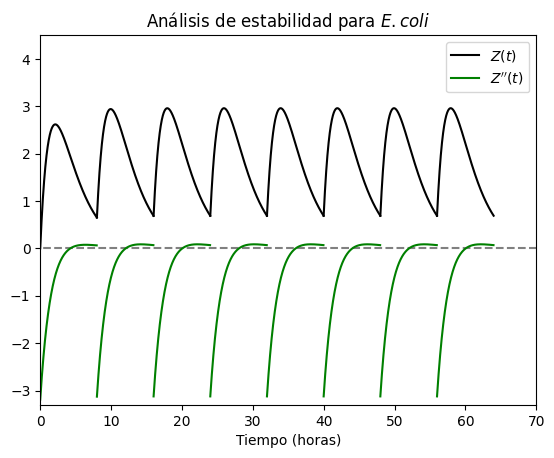

In [304]:
plt.hlines(0, -10, 80, color='grey', linestyles='--')
for i in range(0, 8):
    t = np.arange(8*i, 8 + 8*i, 0.01)
    p1,=plt.plot(t, Z(t, i+1, 8), color='black', label='$Z(t)$')
    p2,=plt.plot(t[:-2], segunda_derivada_de_z(Z, t[0:-2], 0.01, i+1, 8), color='green', label="$Z''(t)$")

plt.legend(loc='upper right',handles=[p1,p2])
plt.ylim(-3.3, 4.5)
plt.xlim(0, 70)
plt.title('Análisis de estabilidad para $E.coli$')
plt.xlabel('Tiempo (horas)')

### Soluciones deterministas

#### Teniendo que el modelo completo es: 
$$
\frac{dx_1}{dt} = \left(1 - \frac{x_{1}}{k_{1}}\right) \alpha_{1}x_{1} - x_{1}\eta_{1}z
$$

$$
z(t) = \left(\frac{k_a d F}{V (k_a - k_e)}\right) \left(\frac{1 - B^n}{1 - B}\right) e^{(-k_e  (t - ((n - 1)  t0)))} - \left(\frac{(k_a  d  F)}{(V  (k_a - k_e))}\right) \left(\frac{1 - A^n}{1 - A}\right)  e^{(-k_a  (t - ((n - 1)  t0)))}
$$

#### Parámetros para la integración numérica

In [305]:
# Parámetros para la función del antibiótico
k_a = 1.3
k_e = 1/8
d = 1000
F = 0.031

# Parámetros del modelo
α1 = 1/18
η1 = 0.015
k1 = 500

# Valores iniciales
x1_0 = 150
c0 = np.array([x1_0])

# Parémtros temporales
dt = 0.01
t0 =8
dosis = int((24/8)*14) # 24/8 = 3 ingestas por día * 20 que sería el número de días del tratamiento
t = np.arange(0, t0*dosis, dt)

#### Funciones para hallar la solución numérica

In [306]:
def Z(t, n_dosis=1, t0=8):  
	A = np.exp(-k_a*t0)
	B = np.exp(-k_e*t0)
	n = n_dosis
	
	V = 6 # Volumen en sangre
 
	parte_a = ((k_a * d * F)/(V * (k_a - k_e))) * ((1 - (B**n))/(1 - B)) * np.exp(-k_e * (t - ((n - 1) * t0)))
	parte_b = ((k_a * d * F)/(V * (k_a - k_e))) * ((1 - (A**n))/(1 - A)) * np.exp(-k_a * (t - ((n - 1) * t0)))
	z = parte_a - parte_b
	return z


def modelo_una_especie_sin_ab(x1, t):     
    dx1dt = (1 - (x1/k1)) * x1 * α1
    return dx1dt


def modelo_una_especie_con_ab(x1, t, n_dosis, t0, factor):
    zt = Z(t, n_dosis, t0) * factor
    dx1dt = ((1 - (x1/k1)) * x1 * α1) - (x1 * η1 * zt)
    #
    return dx1dt

def solucionar_multidosis(dosis, suspension_del_ab=15):
    t0 =8
    sols_arr = []
    z_arr = []
    for n_dosis in range(0, dosis):
        t = np.arange(t0*n_dosis, t0*(n_dosis + 1), dt)
        if n_dosis == 0:
            sol = odeint(modelo_una_especie_con_ab, x1_0, t, args=(n_dosis + 1, t0, 1))
            z_sol = Z(t, n_dosis+1, t0)
            
        elif n_dosis > 0 and n_dosis < suspension_del_ab:
            sol = odeint(modelo_una_especie_con_ab, sol[-1][0], t,  args=(n_dosis + 1, t0, 1))
            z_sol = Z(t, n_dosis+1, t0)
            
        elif n_dosis >= suspension_del_ab:
            sol = odeint(modelo_una_especie_con_ab, sol[-1][0], t,  args=(n_dosis + 1, t0 , 0))
            z_sol = Z(t, suspension_del_ab, t0)
            
        sols_arr.append(sol)
        z_arr.append(z_sol)
    return [np.concatenate(sols_arr), np.concatenate(z_arr)]

#### Solución numérica sin antibiótico

Text(0.5, 1.0, 'Crecimiento de $E.coli$ sin antibiótico')

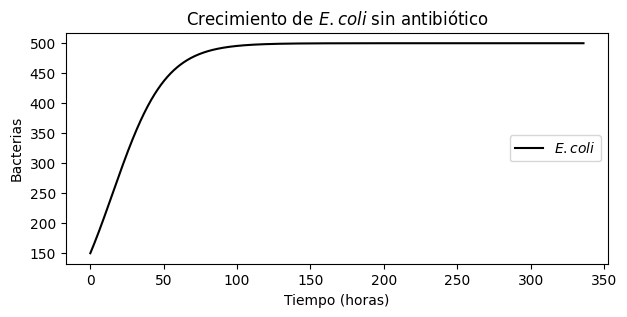

In [307]:
solution_no_ab = odeint(modelo_una_especie_sin_ab, [150], t)
plt.subplots(figsize=(7, 3))
plt.plot(t, solution_no_ab, color='black', label='$E.coli$')
plt.legend(loc='center right')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Bacterias')
plt.title('Crecimiento de $E.coli$ sin antibiótico')

Text(0.5, 1.0, 'Crecimiento de $E.coli$ con antibiótico')

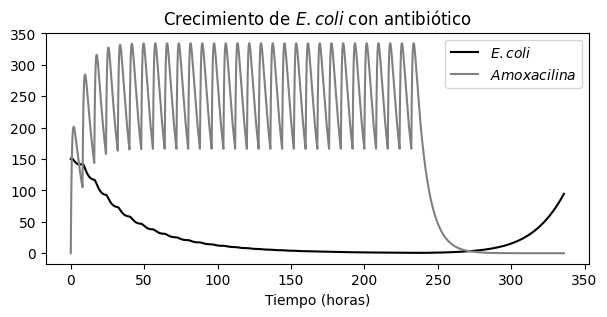

In [308]:
bacteria, antibiotico = solucionar_multidosis(dosis, suspension_del_ab=30) 

plt.subplots(figsize=(7, 3))
plt.plot(t, bacteria, color='black', label='$E.coli$')
plt.plot(t, antibiotico*50, color='grey', label='$Amoxacilina$')
plt.legend(loc='upper right')
plt.xlabel('Tiempo (horas)')
plt.title('Crecimiento de $E.coli$ con antibiótico')

Ajustar el modelo

conc = {0.3, 1.6, 4.6, 6.9, 8.4, 9.5, 8.8, 5.5, 3.1, 1.5, 0.9, 0.7};
time = {20, 30, 45, 60, 75, 90, 120, 180, 240, 300, 360, 420};